## Matching cosmoDC2 Halos to redMaPPer Clusters
### Started July 2020
### Aidan Cloonan

This is an attempt to adapt some methods from Zhang, *et al*. (2020) on Buzzard N-body simulations to cosmoDC2 simulation data. From within the data, clusters from the redMaPPer algorithm will be paired with individual halos through constraints on halo mass, redshift, angular separation, and comoving distance. 

This notebook should include up to a plot of the $\log(\lambda)$-$\log(M_{h})$ relation, where $\lambda$ is the cluster richness and $M_{h}$ is the halo mass. Based on the results from Buzzard, we expect a slight log-linear trend in this plot. The next steps include compiling coordinates for cluster members on a comoving Cartesian scale and calculating the lensed ellipticity of central halos.

In [ ]:
# compile cosmoDC2 data
import GCRCatalogs as gcr

# math
import numpy as np

# plotting
import matplotlib.pyplot as plt
#from tools.plot_utils import plot_pretty
#plot_pretty()

# setup notebook for inline figures
%matplotlib inline

# track progress of loops
from tqdm import *
import time

# astropy packages
import astropy.io.fits as fits                      # fits files
from astropy.table import Table                     # organize data into astropy tables
from astropy.coordinates import SkyCoord            # coordinates
from astropy import units as u                      # units
from astropy.cosmology import FlatLambdaCDM         # cosmological parameters and calculations

In [10]:
# get the redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [11]:
# get the cosmoDC2 catalog
cosmoDC2_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_image')

### Compile Cluster Data

From `redM_gcr`, where redMaPPer is applied to cosmoDC2.

In [12]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)

All redMaPPer quantities:

['scaleval', 'ra_cen_0', 'ra_cen_3', 'redshift', 'p_cen_4', 'p_cen_1', 'mag_g_lsst_member', 'dec_cen_0', 'dec_cen_4', 'magerr_r_lsst_member', 'id_cen_2', 'redshift_err', 'redshift_true_cg', 'ra_cen_2', 'maskfrac', 'dec_cen_2', 'p_cen_0', 'magerr_g_lsst_member', 'p_cen_2', 'id_cen_3', 'mag_z_lsst_member', 'dec_cen_3', 'p_cen_3', 'ra', 'magerr_i_lsst_member', 'theta_r_member', 'cluster_id_member', 'mag_r_lsst_member', 'magerr_z_lsst_member', 'magerr_y_lsst_member', 'richness', 'ra_cen_4', 'dec_member', 'ra_member', 'p_member', 'id_member', 'dec_cen_1', 'mag_i_lsst_member', 'refmag_err_member', 'ra_cen_1', 'dec', 'pfree_member', 'richness_err', 'refmag_member', 'id_cen_1', 'theta_i_member', 'cluster_id', 'mag_y_lsst_member', 'id_cen_0', 'id_cen_4', 'redshift_true_member']

Cluster quantities:

['scaleval', 'ra_cen_0', 'ra_cen_3', 'redshift', 'p_cen_4', 'p_cen_1', 'dec_cen_0', 'dec_cen_4', 'id_cen_2', 'redshift_err', 'redshift_true_cg', 'ra_cen_2', 'maskfrac', 'd

In [13]:
# read in the cluster data
redM_data = Table(redM_gcr.get_quantities(cluster_quantities))

In [14]:
# how many clusters are there in redMaPPer?
assert len(redM_data['redshift']) == len(redM_data['cluster_id']) == len(redM_data['ra']) == len(redM_data['dec'])
print("There are {} clusters in the cosmoDC2 redMaPPer algorithm.".format(len(redM_data)))

There are 3895 clusters in the cosmoDC2 redMaPPer algorithm.


### Compile Halo Data

From `cosmoDC2_gcr`, which includes all data from the cosmoDC2 simulation.

In [8]:
# how many halos are there before filtering for halo mass?
unfiltered_halo_id = Table(cosmoDC2_gcr.get_quantities('halo_id'))
print("There are {} halos in all of cosmoDC2.".format(len(unfiltered_halo_id['halo_id'])))

There are 2256249331 halos in all of cosmoDC2.


In [15]:
# list wanted halo quantities, with a filter on halo_mass
halo_quantities_wanted = ['halo_mass'
                          , 'halo_id'
                          , 'redshift'
                          , 'ra'
                          , 'dec'
                          , 'galaxy_id']
query = gcr.GCRQuery('halo_mass > 1e13')

In [16]:
# read in the halo data
halos_data = Table(cosmoDC2_gcr.get_quantities(halo_quantities_wanted, [query]))

In [17]:
# how many halos are there in the filtered halo data?
assert (len(halos_data['halo_mass'])
        == len(halos_data['redshift'])
        == len(halos_data['halo_id']) 
        == len(halos_data['ra'])
        == len(halos_data['dec'])
        == len(halos_data['galaxy_id'])
        )
print("There are {} halos in our unfiltered dataset.".format(len(halos_data['halo_id'])))

There are 11298557 halos in our unfiltered dataset.


In [18]:
# filter out duplicate halos
unique_ID, unique_ind = np.unique(halos_data['halo_id'], return_index=True)
filtered_halos_data = halos_data[unique_ind]
print ("There are {} unique halos in the dataset.".format(len(filtered_halos_data)))

There are 471966 unique halos in the dataset.


In [19]:
# check that there aren't duplicate galaxy IDs in the filtered data
unique_gal, unique_gal_ind = np.unique(filtered_halos_data['galaxy_id'], return_index=True)
print("There are {} duplicate galaxy IDs in the filtered data.".format(len(filtered_halos_data) - len(unique_gal_ind)))

There are 0 duplicate galaxy IDs in the filtered data.


### Scatterplot of Simulated Positions of Halos and Clusters

This lets us know that there are halos that can definitely be matched with clusters.

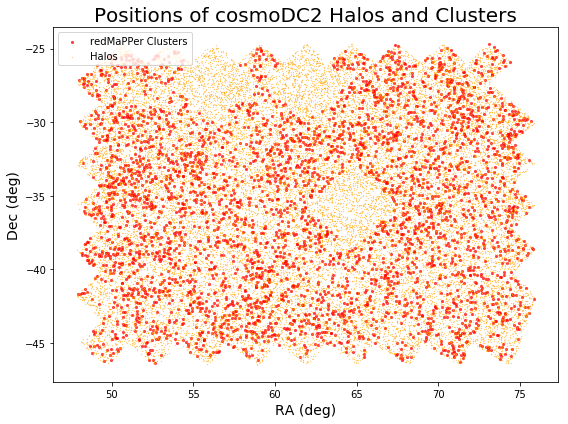

In [20]:
# Scatter plot to inspect that halos match clusters
plt.figure(figsize=(8,6))
plt.scatter(redM_data['ra'], redM_data['dec'], c='r', s=10, alpha=0.75, marker='o',linewidth=0.0, label='redMaPPer Clusters')
plt.scatter(filtered_halos_data['ra'][::15], filtered_halos_data['dec'][::15], c='orange', marker='.', s=7, linewidth=0.0, alpha=0.5, label='Halos')

plt.xlabel('RA (deg)', fontsize=14); plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of cosmoDC2 Halos and Clusters', fontsize=20)
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

### Extract Parameters from Table Files

In [21]:
# clusters
redM_id = redM_data['cluster_id']
redM_ra = redM_data['ra']; redM_dec = redM_data['dec']
redM_z = redM_data['redshift']
redM_lambda = redM_data['richness']

# halos
halos_id = filtered_halos_data['halo_id']
halos_ra = filtered_halos_data['ra']; halos_dec = filtered_halos_data['dec']
halos_z = filtered_halos_data['redshift']
halos_mass = filtered_halos_data['halo_mass']

### Matching Test: Angular Separation

For each cluster, find the halo of least angular separation, using a sample of the redMaPPer clusters.

In [22]:
# using find_nearest_halo, iterate through array and find index of matches
# go through the richness-mass template finder

# define coordinates for clusters and halos
redM_coord = SkyCoord(redM_ra*u.deg, redM_dec*u.deg, frame='icrs')
halos_coord = SkyCoord(halos_ra*u.deg, halos_dec*u.deg, frame='icrs')

# define find_nearest_halo, which identifies the nearest halo neighbor for clusters
def find_nearest_halo(ind):
    dist_sep = halos_coord.separation(redM_coord[ind])
    index = np.abs(dist_sep).argmin()
    return index, dist_sep[index].value

In [12]:
# test find_nearest_halo on some indices in redM_coord
# each cluster should have a specific match

test_arr = np.arange(0, 1500, 50)

for i, test_ind in enumerate(test_arr):
    ind, dist = find_nearest_halo(test_ind)
    print("redMaPPer index: ", test_ind)
    print("Matched halo index: ", ind)
    print("Total angular separation: ", dist)
    print("RA difference: ", halos_ra[ind] - redM_ra[test_ind])
    print("DEC difference: ", halos_dec[ind] - redM_dec[test_ind])
    print("Redshift difference: {} \n".format(redM_z[test_ind] - halos_z[ind]))

redMaPPer index:  0
Matched halo index:  189191
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: 0.002773893074108802 

redMaPPer index:  50
Matched halo index:  206773
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: 0.004923209526674022 

redMaPPer index:  100
Matched halo index:  96606
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: 0.011478002887527872 

redMaPPer index:  150
Matched halo index:  317832
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: 0.0030331603928983597 

redMaPPer index:  200
Matched halo index:  16046
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: 0.0016351528734610543 

redMaPPer index:  250
Matched halo index:  15882
Total angular separation:  0.0
RA difference:  0.0
DEC difference:  0.0
Redshift difference: -0.0010443349125766055 

redMaP

In [23]:
print(redM_ra[0], redM_dec[0])
print(halos_ra[189191], halos_dec[189191])

52.520436430812914 -25.717996124671657
52.520436430812914 -25.717996124671657


### Running Angular Separation Code for all redMaPPer Clusters

This might take some time.

In [24]:
# recall SkyCoord data
redM_coord = SkyCoord(redM_ra*u.deg, redM_dec*u.deg, frame='icrs')
halos_coord = SkyCoord(halos_ra*u.deg, halos_dec*u.deg, frame='icrs')

# recall find_nearest_halo
def find_nearest_halo(ind):
    dist_sep = halos_coord.separation(redM_coord[ind])
    index = np.abs(dist_sep).argmin()
    return index, dist_sep[index].value

# set some limits for max angular separation and redshift difference
ang_lim = 1e-5
z_lim = 0.05

In [25]:
# now, loop through all of redM_data

centered_redM_ind = [] #for clusters
centered_halo_ind = [] #for halos

for i, cluster in tqdm(enumerate(redM_data)):
    
    # track progress
    time.sleep(0.001)
    
    # info for each cluster
    cluster_id = cluster['cluster_id']
    cluster_ra = cluster['ra']; cluster_dec = cluster['dec']
    cluster_z = cluster['redshift']
    
    ind, ang_sep = find_nearest_halo(i)   # find angular separation
    z_dif = np.abs(cluster_z - halos_z[ind]) #   redshift difference
    
    # only match halo to cluster if calculations fall within limits
    if (ang_sep <= ang_lim) & (z_dif <= z_lim):
        centered_redM_ind.append(i)
        centered_halo_ind.append(ind)
      
    '''
    if i % 10 == 0:
        print("Processing cluster number", i)
        print("Number of centered clusters:", len(centered_redM_ind))
    '''

3895it [05:24, 12.00it/s]


In [26]:
print("Out of {} redMaPPer clusters, {} were centered.".format(len(redM_data), len(centered_redM_ind)))

Out of 3895 redMaPPer clusters, 3344 were centered.


In [27]:
# compile all centered and miscentered indices

miscent_redM_ind = np.delete(range(len(redM_data)), centered_redM_ind)
redM_cent = np.asarray(redM_data[centered_redM_ind])
redM_miscent = np.asarray(redM_data[miscent_redM_ind])

miscent_halo_ind = np.delete(range(len(filtered_halos_data)), centered_halo_ind)
halos_cent = np.asarray(filtered_halos_data[centered_halo_ind])
halos_miscent = np.asarray(filtered_halos_data[miscent_halo_ind])

print("Number of centered clusters: {}".format(len(redM_cent)))
print("Number of miscentered clusters: {}".format(len(redM_miscent)))
print("Total number of redMaPPer clusters: {}".format(len(redM_data)))

print("\nNumber of centered halos: {}".format(len(halos_cent)))
print("Number of miscentered halos: {}".format(len(halos_miscent)))
print("Total number of cosmoDC2 halos: {}".format(len(filtered_halos_data)))

Number of centered clusters: 3344
Number of miscentered clusters: 551
Total number of redMaPPer clusters: 3895

Number of centered halos: 3344
Number of miscentered halos: 468622
Total number of cosmoDC2 halos: 471966


### Diagnosis Plots for Centered Halos and Clusters

#### Halo Mass Distribution

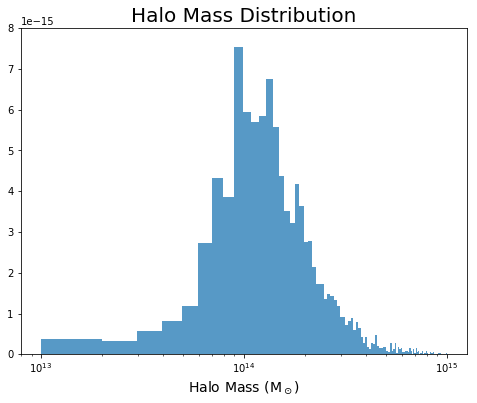

In [28]:
mass_range = (1e13, 1e15)

plt.figure(figsize=(8,6))
plt.hist(halos_cent['halo_mass'], 100, mass_range, density=True, alpha=0.75)
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
#plt.rc('axes', labelsize=14)
plt.ylim(0, 8e-15)
plt.title('Halo Mass Distribution', fontsize=20)
plt.show()

#### Distribution of Redshift Difference

Note the cutoff at $\Delta{z} = 0.05$.

Text(0.5, 1.0, 'Distribution of Redshift Difference')

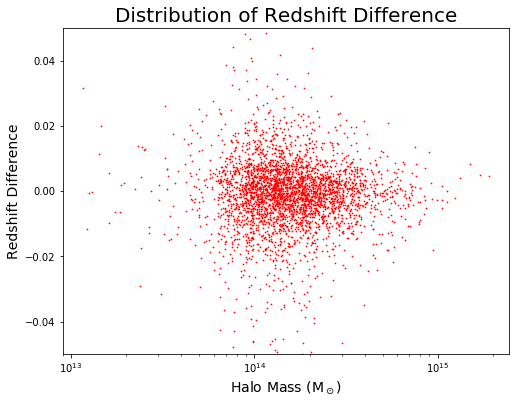

In [29]:
delta_z = redM_cent['redshift'] - halos_cent['redshift']

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], delta_z, s=0.5, c='r')
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Redshift Difference', fontsize=14)
plt.ylim(-0.05, 0.05)
plt.title('Distribution of Redshift Difference', fontsize=20)

#### Distribution of Angular Separation

Note the cutoff at $\Delta{\theta} = 10^{-5}$ degrees.

Text(0.5, 1.0, 'Distribution of Angular Separation')

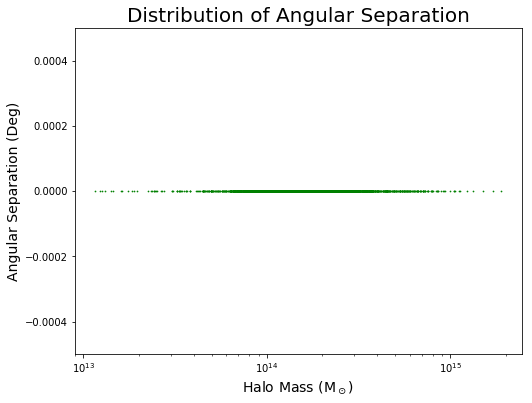

In [30]:
ang_sep = np.sqrt((halos_cent['ra'] - redM_cent['ra'])**2 + (halos_cent['dec']-redM_cent['dec'])**2)

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], ang_sep, s=0.5, c='g')
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Angular Separation (Deg)', fontsize=14)
plt.ylim(-0.0005, 0.0005)
plt.title('Distribution of Angular Separation', fontsize=20)

#### $\log(\lambda)$-$\log(M)$ Relation

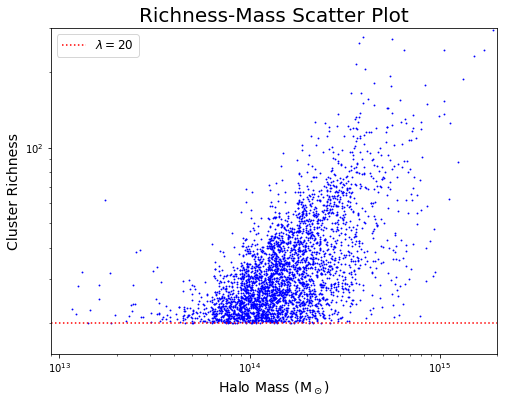

In [31]:
x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_cent['halo_mass'], redM_cent['richness'], s=0.75, c='b')
plt.plot(x,y,':r', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass Scatter Plot', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

### Matching Miscentered Halos and Clusters

Centered clusters are automatically assigned a halo. This algorithm will apply to miscentered clusters.

There are some trigonometric calculations involved in this. As a result, we need to convert the RA and Dec values into radians.

First, though, we'll need to define the cosmology according to the parameters outlined [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

**Note**: I did not account for the cosmology of the cosmoDC2 simulation during my first few runs of this notebook, but I just used that of WMAP9. I should run this again with a more accurate cosmology, defined below. That being said, I'll need to figure out how to account for $\sigma_{8} = 0.8$ and $n_{s} = 0.963$.

In [32]:
# define the cosmology
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)

In [32]:
# extract parameters again, but only for miscentered clusters and halos

# clusters
mredM_id = redM_miscent['cluster_id']
mredM_ra = redM_miscent['ra'] * np.pi/180;        # CONVERT TO RADIANS
mredM_dec = redM_miscent['dec'] * np.pi/180       # CONVERT TO RADIANS
mredM_z = redM_miscent['redshift']
mredM_lambda = redM_miscent['richness']

# halos
mhalos_id = halos_miscent['halo_id']
mhalos_ra = halos_miscent['ra'] * np.pi/180;      # CONVERT TO RADIANS
mhalos_dec = halos_miscent['dec'] * np.pi/180     # CONVERT TO RADIANS
mhalos_z = halos_miscent['redshift']
mhalos_mass = halos_miscent['halo_mass']

# extract comoving distance
mredM_comvd = cosmo.comoving_distance(mredM_z).value
mhalos_comvd = cosmo.comoving_distance(mhalos_z).value

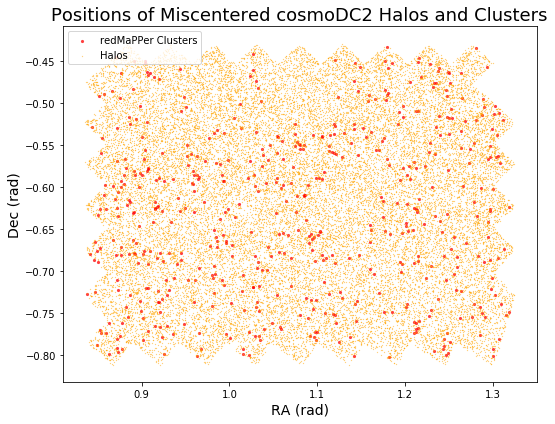

In [33]:
# halos still match clusters
plt.figure(figsize=(8,6))
plt.scatter(mredM_ra, mredM_dec, c='r', s=10, alpha=0.75, marker='o',linewidth=0.0, label='redMaPPer Clusters')
plt.scatter(mhalos_ra[::15], mhalos_dec[::15], c='orange', marker='.', s=7, linewidth=0.0, alpha=0.5, label='Halos')

plt.xlabel('RA (rad)', fontsize=14); plt.ylabel('Dec (rad)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of Miscentered cosmoDC2 Halos and Clusters', fontsize=18)
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

#### Halo-Cluster Algorithm

We'll set limits on redshift difference and comoving distance of $\Delta{z} < 0.05$ and $D_{com} < 2$ Mpc h$^{-1}$, respectively.

In [34]:
z_lim = 0.05
comvd_lim = 2

In [35]:
# sort indices for mhalos_mass
mhalos_sorted = np.asarray(sorted(range(len(mhalos_mass)),key=lambda x:mhalos_mass[x],reverse=True))
print("Number of halos:", mhalos_sorted.shape[0])

Number of halos: 468622


In [36]:
# go down list of halos from most to least massive and find potential cluster matches

redM_match_ind = np.array([])  # indices of (potentially) matched clusters
redM_uniq_ind = np.array([])   # unique indices to select uniquely matched clusters

for i in tqdm(range(mhalos_sorted.shape[0])):
    
    # track progress, this is a long one
    time.sleep(1e-20)

    # parameters for the single halo
    cur_halo_ra = mhalos_ra[mhalos_sorted[i]]; 
    cur_halo_dec = mhalos_dec[mhalos_sorted[i]]
    cur_halo_z = mhalos_z[mhalos_sorted[i]]
    cur_halo_comvd = mhalos_comvd[mhalos_sorted[i]]
    
    # assume clusters that fall in this redshift range have the same redshift as the halo
    # find distance to the halo according to this assumption, and find ones local to the halo
    z_lim_redM_ind = np.asarray(np.where(np.abs(cur_halo_z - mredM_z) < z_lim)[0])

    # filter clusters in redshift proximity region
    mredM_ra_zfilt = mredM_ra[z_lim_redM_ind]
    mredM_dec_zfilt = mredM_dec[z_lim_redM_ind]

    
    # use spherical law of cosines to find angle difference from RA, Dec
    d_lmda = mredM_ra_zfilt - cur_halo_ra
    d_Sigma = np.arccos(np.sin(mredM_dec_zfilt)*np.sin(cur_halo_dec)+\
                        np.cos(mredM_dec_zfilt)*np.cos(cur_halo_dec)*np.cos(d_lmda))
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * cur_halo_comvd**2. * (1. - np.cos(d_Sigma)))
    
    # find eligible local clusters based on proximity, and remove repeat clusters already taken by
    # higher mass halos
    loc_redM_ind = z_lim_redM_ind[np.where(dist_cmv < comvd_lim)]
    loc_redM_ind = np.setdiff1d(loc_redM_ind, redM_uniq_ind) # remove clusters already taken by 
                                                            # higher mass halos
    # if there are local clusters present, find the richest
    if np.size(loc_redM_ind) > 0:
        cur_redM_match_ind = loc_redM_ind[np.argmax(mredM_lambda[loc_redM_ind])]
        redM_uniq_ind = np.append(redM_uniq_ind, redM_match_ind)
    
    else:
        cur_redM_match_ind = -1         # -1 for no match
        
    redM_match_ind = np.concatenate((redM_match_ind, [cur_redM_match_ind]))
        
    if i%1e5 == 0:
        print("Matching halo number ", i)
        #print("Number of clusters in redshift bin: ", np.shape(z_lim_redM_ind))
        #print("Number of local clusters in distance range: ", np.shape(loc_redM_ind))
        print("Number of clusters matched to halos: {}\n".format(np.shape(np.where(redM_match_ind>-1))[1]))

  0%|          | 489/468622 [00:00<03:04, 2543.62it/s]

Matching halo number  0
Number of clusters matched to halos: 1



 21%|██▏       | 100002/468622 [1:41:41<7:58:07, 12.85it/s]

Matching halo number  100000
Number of clusters matched to halos: 483



 43%|████▎     | 200002/468622 [4:00:40<6:29:56, 11.48it/s] 

Matching halo number  200000
Number of clusters matched to halos: 485



 64%|██████▍   | 300002/468622 [7:02:45<5:33:31,  8.43it/s] 

Matching halo number  300000
Number of clusters matched to halos: 490



 85%|████████▌ | 400002/468622 [10:35:43<2:58:44,  6.40it/s] 

Matching halo number  400000
Number of clusters matched to halos: 492



100%|██████████| 468622/468622 [13:51:42<00:00,  9.39it/s]  


In [37]:
# how many clusters got matched to halos?
print("Number of clusters matched to halos: {}".format(np.shape(np.where(redM_match_ind>-1))[1]))

Number of clusters matched to halos: 495


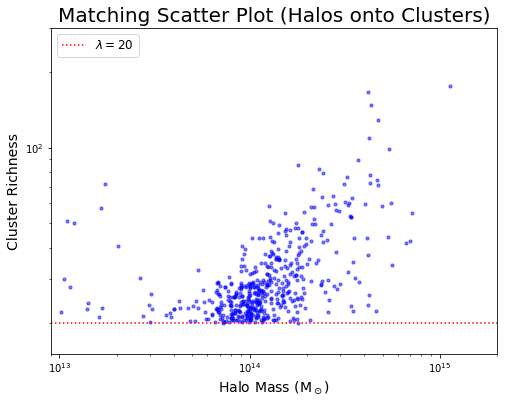

In [38]:
# sample of mass-richness using matched clusters
halos_match_ind_hcl = np.where(redM_match_ind != -1)
halos_mass_match_hcl = mhalos_mass[mhalos_sorted[halos_match_ind_hcl]]
redM_lambda_match_hcl = mredM_lambda[np.asarray(redM_match_ind[halos_match_ind_hcl],dtype=int)]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_mass_match_hcl, redM_lambda_match_hcl, c='b', alpha=0.5,s=10)
plt.plot(x,y,':r', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Matching Scatter Plot (Halos onto Clusters)', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Cluster-Halo Algorithm

We're using the same constraints of $\Delta{z} < 0.05$ and $D_{com} < 2$ Mpc h$^{-1}$.

In [39]:
# sort indices for mhalos_mass
mredM_sorted = np.asarray(sorted(range(len(mredM_lambda)),key=lambda x:mredM_lambda[x],reverse=True))
print("Number of clusters:", mredM_sorted.shape[0])

Number of clusters: 551


In [40]:
# go down list of clusters from most to least rich and find potential halo matches

halos_match_ind = np.array([])  # indices of (potentially) matched halos
halos_uniq_ind = np.array([])   # unique indices to select uniquely matched halos

for i in tqdm(range(mredM_sorted.shape[0])):

    # track progress
    time.sleep(1e-20)
    
    # parameters for the single halo
    cur_redM_ra = mredM_ra[mredM_sorted[i]]; 
    cur_redM_dec = mredM_dec[mredM_sorted[i]]
    cur_redM_z = mredM_z[mredM_sorted[i]]
    cur_redM_comvd = mredM_comvd[mredM_sorted[i]]
    
    # assume halos that fall in this redshift range have the same redshift as the cluster
    # find distance to the cluster according to this assumption, and find ones local to the cluster
    z_lim_halo_ind = np.asarray(np.where(np.abs(cur_redM_z - mhalos_z) < z_lim)[0])

    # filter halos in redshift proximity region
    mhalo_ra_zfilt = mhalos_ra[z_lim_halo_ind]
    mhalo_dec_zfilt = mhalos_dec[z_lim_halo_ind]

    
    # use spherical law of cosines to find angle difference from RA, Dec
    d_lmda = mhalo_ra_zfilt - cur_redM_ra
    d_Sigma = np.arccos(np.sin(mhalo_dec_zfilt)*np.sin(cur_redM_dec)+\
                        np.cos(mhalo_dec_zfilt)*np.cos(cur_redM_dec)*np.cos(d_lmda))
    
    # find comoving distance between halos and clusters from law of cosines for clusters in same
    # comoving distance, using the halo's redshift
    dist_cmv = np.sqrt(2 * cur_redM_comvd**2. * (1. - np.cos(d_Sigma)))
    
    # find eligible local clusters based on proximity, and remove repeat clusters already taken by
    # higher mass halos
    loc_halo_ind = z_lim_halo_ind[np.where(dist_cmv < comvd_lim)]
    loc_halo_ind = np.setdiff1d(loc_halo_ind, halos_uniq_ind) # remove halos already taken by 
                                                              # richer clusters
    # if there are local halos present, find the most massive
    if np.size(loc_halo_ind) > 0:
        cur_halo_match_ind = loc_halo_ind[np.argmax(mhalos_mass[loc_halo_ind])]
        halos_uniq_ind = np.append(halos_uniq_ind, halos_match_ind)
    
    else:
        cur_halo_match_ind = -1         # -1 for no match
        
    halos_match_ind = np.concatenate((halos_match_ind, [cur_halo_match_ind]))
        
    '''
    if i%1e2 == 0:
        print("Matching cluster number ", i)
        #print("Number of clusters in redshift bin: ", np.shape(z_lim_redM_ind))
        #print("Number of local clusters in distance range: ", np.shape(loc_redM_ind))
        print("Number of halos matched to clusters: {}\n".format(np.shape(np.where(halos_match_ind>-1))[1]))
        '''
        
print("Done!")

100%|██████████| 551/551 [00:05<00:00, 102.27it/s]

Done!


In [41]:
# how many halos got matched to clusters?
print("Number of clusters matched to halos: {}\n".format(np.shape(np.where(halos_match_ind>-1))[1]))

Number of clusters matched to halos: 491



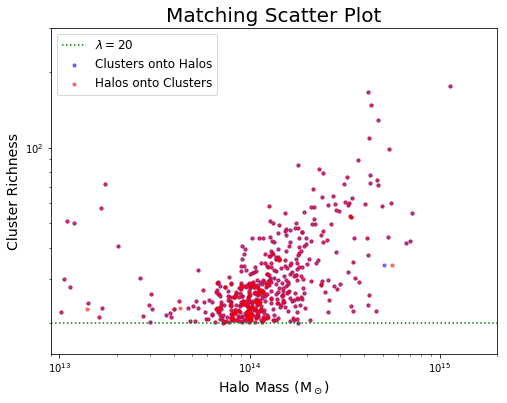

In [42]:
# sample of mass-richness using matched halos

redM_match_ind_clh = np.where(halos_match_ind != -1)
redM_lambda_match_clh = mredM_lambda[mredM_sorted[redM_match_ind_clh]]
halos_mass_match_clh = mhalos_mass[np.asarray(halos_match_ind[redM_match_ind_clh],dtype=int)]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_mass_match_clh, redM_lambda_match_clh, c='b', alpha=0.5,s=10, label='Clusters onto Halos')
plt.scatter(halos_mass_match_hcl, redM_lambda_match_hcl, c='r', alpha=0.5,s=10, label='Halos onto Clusters')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Matching Scatter Plot', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

#### Debugging

In [43]:
# check that in redM_match_ind, the clusters matched to halos are physically adjacent, and check
# for redshift

# clusters
print("Checking redM_match_ind...")
redM_match_ind_full = np.where(redM_match_ind != -1)
redM_zfilt = np.asarray(redM_match_ind[redM_match_ind_full], dtype=int)
mhalos_z_sorted = np.asarray(mhalos_z[mhalos_sorted])
redM_zdiff = mhalos_z_sorted[redM_match_ind_full] - mredM_z[redM_zfilt]

redM_z_excess = [x for i, x in enumerate(redM_zdiff) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess), "\n")

# repeat for halos and halos_match_ind
print("Checking halos_match_ind...")
halos_match_ind_full = np.where(halos_match_ind != -1)
halos_zfilt = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
mredM_z_sorted = np.asarray(mredM_z[mredM_sorted])
halos_zdiff = mredM_z_sorted[halos_match_ind_full] - mhalos_z[halos_zfilt]

halos_z_excess = [x for i, x in enumerate(halos_zdiff) if x > z_lim]
print("Redshift differences outside of specified range:", len(halos_z_excess), "\n")

# see if unsorting algorithm works as specified. redM_match_ind and halos_match_ind have indices
# sorted by halo mass and cluster rank. again check for redshift

# find unsorted halos to match to clusters
print("Checking for redM_match_ind unsorted matching...")
a = np.asarray(redM_match_ind[redM_match_ind_full], dtype=int)
b = np.asarray(mhalos_sorted[redM_match_ind_full], dtype=int)
redM_zdiff2 = mhalos_z[b] - mredM_z[a]
redM_z_excess2 = [x for i, x in enumerate(redM_zdiff2) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess2), '\n')

# find unsorted clusters to match to halos
print("Checking for halos_match_ind unsorted matching...")
c = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
d = np.asarray(mredM_sorted[halos_match_ind_full], dtype=int)
halos_zdiff2 = mredM_z[d] - mhalos_z[c]
halos_z_excess2 = [x for i, x in enumerate(halos_zdiff2) if x > z_lim]
print("Redshift differences outside of specified range:", len(halos_z_excess2), '\n')

print("Unsort full arrays and then check for match.")
redM_match_ind_unsorted = np.array(redM_match_ind, dtype=int)

trim_mhalos_sorted = []
idx = 0
while(idx < len(redM_match_ind_unsorted)):
    val = mhalos_sorted[idx]
    trim_mhalos_sorted.append(val)
    idx += 1
trim_mhalos_sorted = np.asarray(trim_mhalos_sorted)
print(np.max(trim_mhalos_sorted))

redM_match_ind_unsorted[trim_mhalos_sorted] = redM_match_ind
#redM_match_ind_unsorted[mhalos_sorted] = redM_match_ind

uniq_match_ind = np.where(redM_match_ind_unsorted != -1)  # referring to unsorted halos
uniq_match_val = redM_match_ind_unsorted[uniq_match_ind]  # matched clusters to unsorted halos
redM_zdiff3 = mhalos_z[uniq_match_ind] - mredM_z[uniq_match_val]
redM_z_excess3 = [x for i, x in enumerate(redM_zdiff3) if x > z_lim]
print("Redshift differences outside of specified range:", len(redM_z_excess3))

print("Checking that uniq_match_ind are the same halos (albeit in the wrong order)...")
e = mhalos_z[uniq_match_ind]
f = mhalos_z_sorted[redM_match_ind_full]
g = np.setdiff1d(e, f)
print("Different halos in sorted and unsorted (order doesn't matter):", len(g))

Checking redM_match_ind...
Redshift differences outside of specified range: 0 

Checking halos_match_ind...
Redshift differences outside of specified range: 0 

Checking for redM_match_ind unsorted matching...
Redshift differences outside of specified range: 0 

Checking for halos_match_ind unsorted matching...
Redshift differences outside of specified range: 0 

Unsort full arrays and then check for match.
468621
Redshift differences outside of specified range: 0
Checking that uniq_match_ind are the same halos (albeit in the wrong order)...
Different halos in sorted and unsorted (order doesn't matter): 0


### Uniqueness Algorithm

If a cluster matches onto a halo, then that halo matches onto that cluster.

In [44]:
# clusters
redM_match_ind_unsorted = np.array(redM_match_ind, dtype=int)
redM_match_ind_unsorted[mhalos_sorted] = redM_match_ind

# halos
halos_match_ind_unsorted = np.array(halos_match_ind, dtype=int)
halos_match_ind_unsorted[mredM_sorted] = halos_match_ind

uniq_match_ind = np.where(redM_match_ind_unsorted != -1)  # unsorted halos
uniq_match_val = redM_match_ind_unsorted[uniq_match_ind]  # matched clusters to unsorted halos
nonuniq_match_val = [x for x in range(len(halos_match_ind_unsorted)) if x not in uniq_match_val]
# assign all non_uniq halos to -1

uniq_match_bool = halos_match_ind_unsorted[uniq_match_val] == uniq_match_ind
uniq_match_bool = uniq_match_bool[0]
print("Number of one way clusters matched to halos:", np.shape(halos_match_ind_unsorted[uniq_match_val]))
print("Number of unique matches:", np.shape(np.where(uniq_match_bool == True)))

a = np.array(halos_match_ind_unsorted[uniq_match_val])
np.place(a, uniq_match_bool==False, -1)
halos_match_ind_unsorted[uniq_match_val] = a
halos_match_ind_unsorted[nonuniq_match_val] = -1
halos_uniq_ind_unsorted = np.copy(halos_match_ind_unsorted)

# final cuts
mredM_cut = np.where(halos_uniq_ind_unsorted != -1)
mhalos_cut = halos_uniq_ind_unsorted[mredM_cut]

print("Number of unique matches after cutting out non-unique matches:", np.shape(np.where(halos_uniq_ind_unsorted != -1)))

Number of one way clusters matched to halos: (495,)
Number of unique matches: (1, 490)
Number of unique matches after cutting out non-unique matches: (1, 488)


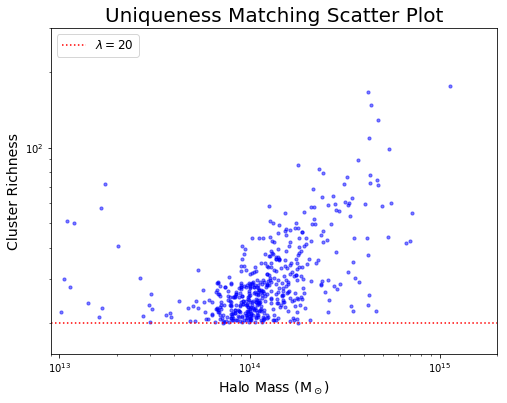

In [45]:
mredM_lambda_uniq = mredM_lambda[mredM_cut]
mhalos_mass_uniq = mhalos_mass[mhalos_cut]

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

# plot richness-mass relation using uniqueness algorithm results

plt.figure(figsize=(8,6))
plt.scatter(mhalos_mass_uniq, mredM_lambda_uniq, c='b', alpha=0.5,s=10)
plt.plot(x,y,':r', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Uniqueness Matching Scatter Plot', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

### Merging Data

In [46]:
mredM_matched = np.asarray(redM_miscent[mredM_cut])
mhalos_matched = np.asarray(halos_miscent[mhalos_cut])

assert len(mredM_matched) == len(mhalos_matched)
assert len(redM_cent) == len(halos_cent)

print("Number of miscentered matched:", len(mredM_matched))
print("Number of centered matched:", len(redM_cent))

Number of miscentered matched: 488
Number of centered matched: 3344


Add a `centered_flag` to tell whether the matching is done automatically by centering or through proximity matching.

https://stackoverflow.com/questions/1201817/adding-a-field-to-a-structured-numpy-array

In [47]:
def add_field(arr, descr):
    """Return a new array that is like "a", but has additional fields.

    Arguments:
      arr    --  a structured numpy array
      descr  --  a numpy type description of the new fields

    The contents of "arr" are copied over to the appropriate fields in
    the new array, whereas the new fields are uninitialized.  The
    arguments are not modified.

    >>> sa = numpy.array([(1, 'Foo'), (2, 'Bar')], \
                         dtype=[('id', int), ('name', 'S3')])
    >>> sa.dtype.descr == numpy.dtype([('id', int), ('name', 'S3')])
    True
    >>> sb = add_field(sa, [('score', float)])
    >>> sb.dtype.descr == numpy.dtype([('id', int), ('name', 'S3'), \
                                       ('score', float)])
    True
    >>> numpy.all(sa['id'] == sb['id'])
    True
    >>> numpy.all(sa['name'] == sb['name'])
    True
    """
    if arr.dtype.fields is None:
        raise (ValueError, "'arr' must be a structured numpy array")
    b = np.empty(arr.shape, dtype=arr.dtype.descr + descr)
    for name in arr.dtype.names:
        b[name] = arr[name]
    return b

# add centered_flag
centered_flag = [('centered_flag', int)]
matching_id = [('matching_id', int)]

mredM_matched = add_field(mredM_matched, centered_flag)
mredM_matched = add_field(mredM_matched, matching_id)
mredM_matched['centered_flag'] = 0

# for centered
redM_cent = add_field(redM_cent, centered_flag)
redM_cent = add_field(redM_cent, matching_id)
redM_cent['centered_flag'] = 1

# for halos
mhalos_matched = add_field(mhalos_matched, matching_id)
halos_cent = add_field(halos_cent, matching_id)

In [49]:
# merging the two
redM_matched = Table(np.append(redM_cent, mredM_matched))
halos_matched = Table(np.append(halos_cent, mhalos_matched))

# assign unique matching ID
matching_ids = range(0, len(redM_matched))
redM_matched['matching_id'] = matching_ids
halos_matched['matching_id'] = matching_ids

# convert R_v from kpc to Mpc
#halos_matched['R_v'] /= 1000

print(redM_matched.dtype)
print(halos_matched.dtype)

[('scaleval', '<f4'), ('ra_cen_0', '<f8'), ('ra_cen_3', '<f8'), ('redshift', '<f4'), ('p_cen_4', '<f4'), ('p_cen_1', '<f4'), ('dec_cen_0', '<f8'), ('dec_cen_4', '<f8'), ('id_cen_2', '<i8'), ('redshift_err', '<f4'), ('redshift_true_cg', '<f4'), ('ra_cen_2', '<f8'), ('dec_cen_2', '<f8'), ('p_cen_0', '<f4'), ('p_cen_2', '<f4'), ('id_cen_3', '<i8'), ('dec_cen_3', '<f8'), ('p_cen_3', '<f4'), ('ra', '<f8'), ('richness', '<f4'), ('ra_cen_4', '<f8'), ('dec_cen_1', '<f8'), ('ra_cen_1', '<f8'), ('dec', '<f8'), ('richness_err', '<f4'), ('id_cen_1', '<i8'), ('cluster_id', '<i4'), ('id_cen_0', '<i8'), ('id_cen_4', '<i8'), ('maskfrac', '<f4'), ('centered_flag', '<i8'), ('matching_id', '<i8')]
[('ra', '<f8'), ('halo_id', '<i8'), ('redshift', '<f8'), ('dec', '<f8'), ('halo_mass', '<f8'), ('galaxy_id', '<i8'), ('matching_id', '<i8')]


In [51]:
#halos_matched['R_v'] *= 1000
#print(np.max(halos_matched['R_v']))

In [52]:
# create two fits files out of the tables we've just created
redM_matched.write("fits_files/redM_matched_cosmoDC2.fits", format='fits')
halos_matched.write("fits_files/halos_matched_cosmoDC2.fits", format='fits')

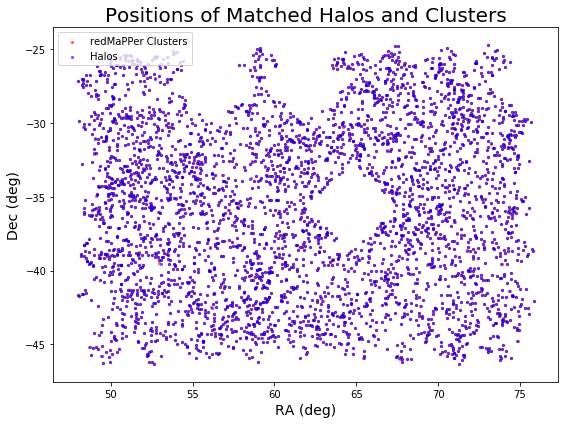

In [53]:
# Scatter plot of matched clusters and halos

plt.figure(figsize=(8,6))
plt.scatter(redM_matched['ra'], redM_matched['dec'], c='r', s=5, alpha=0.5, label='redMaPPer Clusters')
plt.scatter(halos_matched['ra'], halos_matched['dec'], c='b', s=5, alpha=0.5, label='Halos')

plt.xlabel('RA (deg)', fontsize=14); plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of Matched Halos and Clusters', fontsize=20)
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

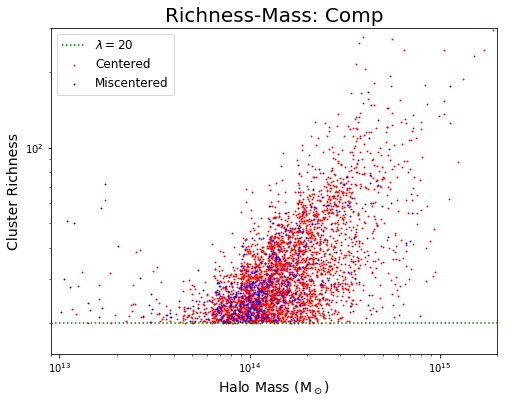

In [54]:
# richness-mass, comparing centered and miscentered

centered = np.where(redM_matched['centered_flag'] == 1)
miscentered = np.where(redM_matched['centered_flag'] == 0)

x = np.linspace(9e12, 2.5e15, 5)
y = 0*x + 20

plt.figure(figsize=(8,6))
plt.scatter(halos_matched[centered]['halo_mass'], redM_matched[centered]['richness'], s=0.75, c='r', label='Centered')
plt.scatter(halos_matched[miscentered]['halo_mass'], redM_matched[miscentered]['richness'], s=0.75, c='b', label='Miscentered')
plt.plot(x,y,':g', label=r'$\lambda = 20$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
plt.ylabel(r'Cluster Richness', fontsize=14)
plt.title('Richness-Mass: Comp', fontsize=20)
plt.xlim(9e12, 2e15)
plt.ylim(15,300)
plt.legend(loc='upper left', fontsize=12)
plt.show()

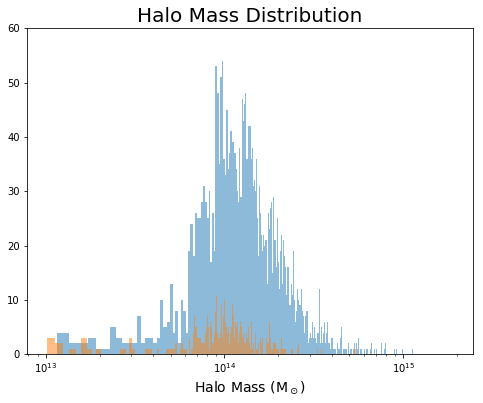

In [55]:
# histogram showing masses for centered and miscentered

plt.figure(figsize=(8,6))
plt.hist(halos_matched[centered]['halo_mass'], bins=1000, alpha=0.5)
plt.hist(halos_matched[miscentered]['halo_mass'], bins=1000, alpha=0.5)
plt.xscale('log')
plt.xlabel(r'Halo Mass (${\rm M}_\odot$)', fontsize=14)
#plt.rc('axes', labelsize=14)
plt.ylim(0, 60)
plt.title('Halo Mass Distribution', fontsize=20)
plt.show()

### References (so far)

Allen S. W., Evrard A. E., Mantz A. B. (2011), "Cosmological Parameters from Observations of Galaxy Clusters," *ARA&A* **49**: 409-470. arXiv:1103.4829

Zhang Z., *et al.* (2020), "Effects of Cluster Triaxiaility on DES Stacked Weak Lensing Analysis," *MNRAS* **(Vol. number)**: 1-19. arXiv: (idk yet)